In [1]:
options(jupyter.plot_mimetypes = c("image/png"))

suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(ggrepel))


## For loading Arial font for publication
# library(extrafont)

# font_import(pattern = "Arial", prompt = FALSE)
# loadfonts(device = "pdf")

Warning message:
“package ‘ggrepel’ was built under R version 4.4.3”


In [2]:
# Read the data
data <- read.csv("resources/freq_alt_func_alleles.hkgp_annotated.csv")

Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”


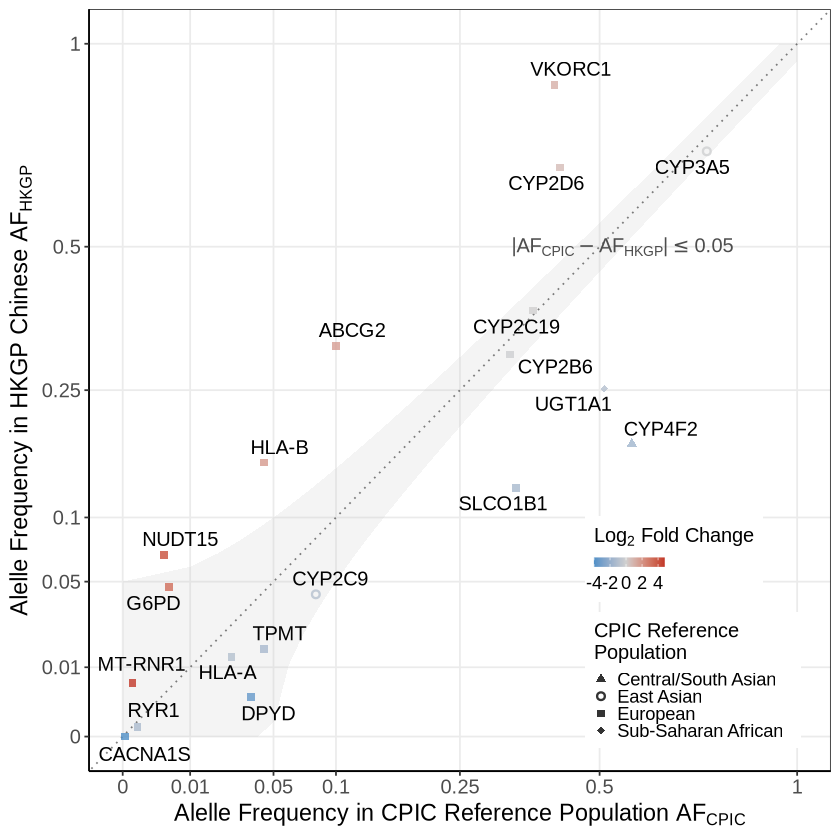

In [3]:
# Initialize constants and calculate fold changes
# ---------------------------------------------

# Add small pseudocount to prevent infinity when calculating fold change
pseudocount <- 1e-6

# Calculate fold change and log2 fold change
data$fold <- (data$EastAsian_HKGP_Chinese + pseudocount) / (data$ref + pseudocount)
data$log2fc <- log2(data$fold)

# Optional: Filter non-finite log2fc values
# data <- data[is.finite(data$log2fc), ]

# Calculate ranges and set up scales
# --------------------------------

# Get range of absolute log2 fold changes
log2fc_range <- range(abs(data$log2fc), na.rm = TRUE)

# Create evenly spaced breaks for size scale
size_breaks <- seq(log2fc_range[1], log2fc_range[2], length.out = 5)

# Define color scheme for populations
pop_colors <- c(
    "European"            = "#808080",  # Muted gray
    "EastAsian"          = "#E41A1C",  # Bright red for emphasis
    "Sub_SaharanAfrican" = "#4DAF4A",  # Green
    "Central_SouthAsian" = "#377EB8"   # Blue
)

# Set shape based on reference population (17 for EastAsian, 16 for others)
data$shape <- ifelse(data$ref_pop == "EastAsian", 17, 16)

# Create confidence band data
# -------------------------

# Generate x values and corresponding y ranges for 0.05 allele frequency difference
x_vals <- seq(0, 1, length.out = 100)
band_df <- data.frame(
    x    = x_vals,
    ymin = pmax(0, pmin(1, x_vals - 0.05)),  # Constrain to [0,1]
    ymax = pmax(0, pmin(1, x_vals + 0.05))   # Constrain to [0,1]
)

# Calculate plot limits
max_x <- max(data$ref)
max_y <- max(data$EastAsian_HKGP_Chinese)
plot_max <- max(max_x, max_y)

# Add offset for TPMT label
data$nudge_x <- ifelse(data$Gene == "TPMT", 0.04, 0)

# Create the main plot
# ------------------

plot1 <- ggplot(data, aes(
    x     = ref,
    y     = EastAsian_HKGP_Chinese,
    shape = ref_pop,
    label = Gene,
    color = log2fc
)) +
    # Add confidence band
    geom_ribbon(
        data = band_df,
        aes(x = x, ymin = ymin, ymax = ymax),
        inherit.aes = FALSE,
        fill = "gray80",
        alpha = 0.2
    ) +
    # Add reference line
    geom_abline(linetype = "dotted", color = "black", alpha = 0.5) +
    # Add data points
    geom_point(alpha = 0.8, stroke = 1) +
    # Add repelled text labels
    geom_text_repel(
        size = 12 / .pt,  # Increased from 6
        color = "black",
        # seed = 412,
        # family = "Arial",
        # max_overlaps = Inf,
        force = 10
    ) +
    # Add confidence band annotation
    annotate(
        "text",
        x = 0.82,
        y = 0.5,
        label = expression("|" * AF[CPIC] - AF[HKGP] * "|" <= 0.05),
        size = 12 / .pt,  # Increased from 6
        hjust = 1,
        # family = "Arial",
        color = "gray30"
    ) +
    # Set color gradient
    scale_color_gradient2(
        low = "#1984c5",
        mid = "#d0d0d0",
        high = "#c23728",
        midpoint = 0,
        name = expression(Log[2]~Fold~Change)
    ) +
    # Configure shape scale
    scale_shape_manual(
        values = c(
            "European"            = 15,
            "EastAsian"          = 1,
            "Sub-SaharanAfrican" = 18,
            "Central_SouthAsian" = 17
        ),
        labels = c(
            "European"            = "European",
            "EastAsian"          = "East Asian",
            "Sub-SaharanAfrican" = "Sub-Saharan African",
            "Central_SouthAsian" = "Central/South Asian"
        ),
        name = "CPIC Reference\nPopulation"
    ) +
    # Configure axis scales with sqrt transformation
    scale_x_sqrt(
        breaks = c(0, 0.01, 0.05, 0.1, 0.25, 0.5, 1),
        labels = c("0", "0.01", "0.05", "0.1", "0.25", "0.5", "1"),
        limits = c(0, 1)
    ) +
    scale_y_sqrt(
        breaks = c(0, 0.01, 0.05, 0.1, 0.25, 0.5, 1),
        labels = c("0", "0.01", "0.05", "0.1", "0.25", "0.5", "1"),
        limits = c(0, 1)
    ) +
    # Set theme
    # theme_bw(base_family = "Arial") +
    theme_bw() +
    theme(
        panel.grid.minor = element_blank(),
        # axis.text.y     = element_text(size = 6),
        # axis.text.x     = element_text(size = 6),
        axis.text.y     = element_text(size = 12),  # Increased from 6
        axis.text.x     = element_text(size = 12),  # Increased from 6
        plot.title      = element_blank(),
        # axis.title.y    = element_text(size = 7),
        # axis.title.x    = element_text(size = 7),
        axis.title.y    = element_text(size = 14),  # Increased from 7
        axis.title.x    = element_text(size = 14),  # Increased from 7
        axis.line       = element_line(color = "black"),
        # legend.title    = element_text(size = 7),
        # legend.text     = element_text(size = 6),
        legend.title    = element_text(size = 12),  # Increased from 7
        legend.text     = element_text(size = 11),  # Increased from 6
        legend.key.size = unit(0.3, "cm")
    ) +
    # Set axis labels
    labs(
        x = expression(Alelle~Frequency~"in"~CPIC~Reference~Population~AF[CPIC]),
        y = expression(Alelle~Frequency~"in"~HKGP~Chinese~AF[HKGP])
    ) +
    # Configure legends
    guides(
        color = guide_colorbar(
            title.position = "top",
            direction = "horizontal",
            barwidth = unit(1.5, "cm"),
            barheight = unit(0.2, "cm")
        ),
        shape = guide_legend(title.position = "top")
    ) +
    theme(
        legend.box = "vertical",
        legend.spacing = unit(0.2, "cm"),
        # legend.color = element_text(margin = margin(b = 5)),
        legend.position.inside = c(0.96, 0.03),  # Moved from c(1, 0) to c(0.8, 0)
        legend.position = 'inside',
        legend.justification = c(1, 0),
        legend.box.margin = margin(1, 1, 1, 1, "mm")
    )

# Display the plot
plot1

# # Export plot to PDF
# ggsave(
#     filename = "results/pgx/pgx_scatterplot.pdf",
#     plot = plot1,
#     width = 90,
#     height = 90,
#     units = "mm",
#     dpi = 600
# )